In [23]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier

# We get a lot of warnings about slices of copies, these are not meaningful.
import warnings
warnings.filterwarnings('ignore')

In [24]:
# Define our source files
COVID_file = 'COVID_by_County/COVID_by_County.csv'
pop_file = 'popData.csv'
US_county_land_file = 'LND01.csv'
US_county_vote_file = 'president_county_candidate.csv'
mask_use_file = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv"

# Read the source files into dataframes.
COVID_data = pd.read_csv(COVID_file)
pop_data = pd.read_csv(pop_file)
land_data = pd.read_csv(US_county_land_file)
vote_data = pd.read_csv(US_county_vote_file)
mask_use = pd.read_csv(mask_use_file)

In [25]:
# Rename some of the columns
COVID_data = COVID_data.rename(columns={'countyFIPS':'fips'})
pop_data = pop_data.rename(columns={'FIPS':'fips', 'Poverty Percent':'Poverty_pct'})
land_data = land_data.rename(columns={'STCOU':'fips','LND010190D':'land'})

# We don't need most of this dataframe so we truncate it down.
land_data = land_data[['fips','land']]

# the vote data is stored as a mixture of row and column data so we jump through hoops to make it usable.
Biden = vote_data[vote_data.candidate == 'Joe Biden']
Trump = vote_data[vote_data.candidate == 'Donald Trump']
vote_data = Biden[['state', 'county', 'total_votes']].copy()
vote_data.rename(columns={'total_votes':'Biden'}, inplace=True)
vote_data['Trump'] = Trump.total_votes.to_numpy()

# We need some definition that allows us to compare to similar categories.
mask_use['mask_pct'] = mask_use['FREQUENTLY'] + mask_use['ALWAYS']

# merge the vote data into the population data, we can't do this on the main dataframe DF because vote data does not use fips.
pop_data = pd.merge(pop_data, vote_data, left_on = ['CTYNAME', 'STNAME'], right_on = ['county','state'])

In [26]:
pop_data['Poverty_pct'].dtype

dtype('float64')

In [27]:
# Merge all the datasets into one main dataframe, DF.  Fioltering down when necessary.
DF = pd.merge(COVID_data, pop_data[['fips', 'POPESTIMATE2018', 'Poverty_pct', 'Biden', 'Trump']], left_on='fips', right_on='fips')
DF = pd.merge(DF,land_data,  left_on='fips', right_on='fips')
DF = pd.merge(DF, mask_use[['COUNTYFP','mask_pct']], left_on = 'fips', right_on = 'COUNTYFP')

# We need to make sure the poverty data is converted from an object type.
#DF.Poverty_pct = DF.Poverty_pct.astype('float')
#it came through as float

# We don't need NaN entries, they will only cause issues.
DF = DF.dropna()

# write out the dataframe to check.
DF

,Dates,fips,County Name,State,cases,deaths,POPESTIMATE2018,Poverty_pct,Biden,Trump,land,COUNTYFP,mask_pct
0,1/22/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739
1,1/23/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739
2,1/24/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739
3,1/25/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739
4,1/26/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739
...,...,...,...,...,...,...,...,...,...,...,...,...,...
982884,12/5/2020,56045,Weston County,WY,419,2,6924,11.8,360,3107,2400.13,56045,0.581
982885,12/6/2020,56045,Weston County,WY,420,2,6924,11.8,360,3107,2400.13,56045,0.581
982886,12/7/2020,56045,Weston County,WY,422,2,6924,11.8,360,3107,2400.13,56045,0.581
982887,12/8/2020,56045,Weston County,WY,425,2,6924,11.8,360,3107,2400.13,56045,0.581


In [28]:
DF.Poverty_pct.dtype

dtype('float64')

In [29]:
# Need to fix some counties that have 0 area in the dataset, data manually found with Google.
DF.land[DF['County Name'] == 'Broomfield County and City'] = 33.55
DF.land[DF['County Name'] == 'Yakutat City and Borough'] = 9463
DF.land[DF['County Name'] == 'Denali Borough'] = 12777
DF.land[DF['County Name'] == 'Skagway Municipality'] = 464
DF.land[DF['County Name'] == 'Wrangell City and Borough'] = 3477

# We create new columns containing per capita data
DF['cases_per_100k'] = DF.cases / DF.POPESTIMATE2018 * 100000
DF['deaths_per_100k'] = DF.deaths / DF.POPESTIMATE2018 * 100000
DF['pop_density'] = DF.POPESTIMATE2018 / DF.land
DF['Biden_per_100k'] = DF.Biden /DF.POPESTIMATE2018 * 100000
DF['Trump_per_100k'] = DF.Trump /DF.POPESTIMATE2018 * 100000
DF

,Dates,fips,County Name,State,cases,deaths,POPESTIMATE2018,Poverty_pct,Biden,Trump,land,COUNTYFP,mask_pct,cases_per_100k,deaths_per_100k,pop_density,Biden_per_100k,Trump_per_100k
0,1/22/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,13510.885419,35722.903499
1,1/23/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,13510.885419,35722.903499
2,1/24/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,13510.885419,35722.903499
3,1/25/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,13510.885419,35722.903499
4,1/26/2020,1001,Autauga County,AL,0,0,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,13510.885419,35722.903499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982884,12/5/2020,56045,Weston County,WY,419,2,6924,11.8,360,3107,2400.13,56045,0.581,6051.415367,28.885038,2.884844,5199.306759,44872.905835
982885,12/6/2020,56045,Weston County,WY,420,2,6924,11.8,360,3107,2400.13,56045,0.581,6065.857886,28.885038,2.884844,5199.306759,44872.905835
982886,12/7/2020,56045,Weston County,WY,422,2,6924,11.8,360,3107,2400.13,56045,0.581,6094.742923,28.885038,2.884844,5199.306759,44872.905835
982887,12/8/2020,56045,Weston County,WY,425,2,6924,11.8,360,3107,2400.13,56045,0.581,6138.070479,28.885038,2.884844,5199.306759,44872.905835


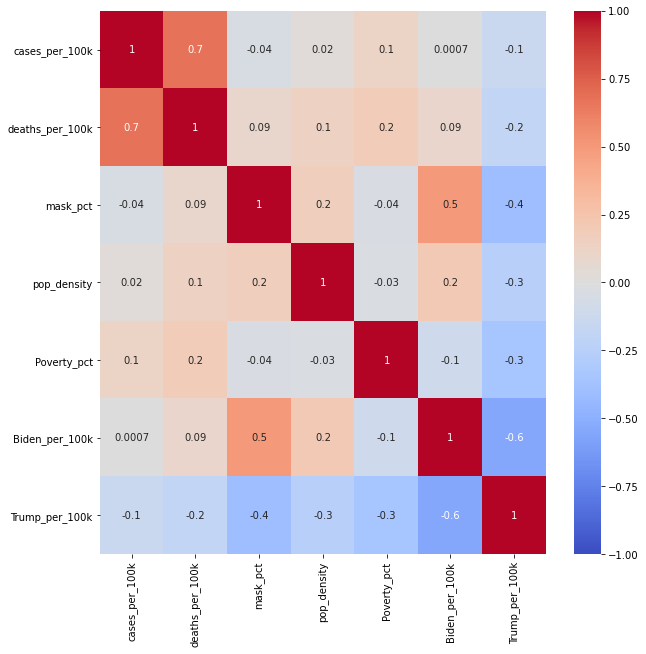

In [30]:
# Print a heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(DF[['cases_per_100k','deaths_per_100k','mask_pct','pop_density','Poverty_pct','Biden_per_100k','Trump_per_100k']].corr(), annot = True, fmt = '0.1g', cmap = 'coolwarm', vmin=-1)

In [31]:
# Create some very macabre fits.
deaths_fit = sm.OLS(DF['deaths_per_100k'],sm.add_constant(DF[['Poverty_pct','pop_density','mask_pct','Biden_per_100k','Trump_per_100k']])).fit()

print(deaths_fit.summary())

                            OLS Regression Results                            
Dep. Variable:        deaths_per_100k   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                 1.435e+04
Date:                Mon, 14 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:03:41   Log-Likelihood:            -5.1283e+06
No. Observations:              982889   AIC:                         1.026e+07
Df Residuals:                  982883   BIC:                         1.026e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.6592      0.492     -1.

In [32]:
cases_fit = sm.OLS(DF['cases_per_100k'],sm.add_constant(DF[['Poverty_pct','pop_density','mask_pct','Biden_per_100k','Trump_per_100k']])).fit()

print(cases_fit.summary())

                            OLS Regression Results                            
Dep. Variable:         cases_per_100k   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     6908.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:03:43   Log-Likelihood:            -8.7159e+06
No. Observations:              982889   AIC:                         1.743e+07
Df Residuals:                  982883   BIC:                         1.743e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2946.6922     18.943    155.

In [33]:
# Create a reduced data frame with just one time slice.
RDF = DF[DF['Dates'] == '12/9/2020']
RDF

,Dates,fips,County Name,State,cases,deaths,POPESTIMATE2018,Poverty_pct,Biden,Trump,land,COUNTYFP,mask_pct,cases_per_100k,deaths_per_100k,pop_density,Biden_per_100k,Trump_per_100k
322,12/9/2020,1001,Autauga County,AL,3117,42,55533,13.8,7503,19838,604.49,1001,0.739,5612.878829,75.630706,91.867525,13510.885419,35722.903499
645,12/9/2020,1003,Baldwin County,AL,10087,141,217855,9.8,24578,83544,2027.08,1003,0.759,4630.143903,64.721948,107.472325,11281.815887,38348.442772
968,12/9/2020,1005,Barbour County,AL,1245,30,24872,30.9,4816,5622,904.59,1005,0.692,5005.628820,120.617562,27.495329,19363.139273,22603.731103
1291,12/9/2020,1007,Bibb County,AL,1322,39,22367,21.8,1986,7525,625.50,1007,0.850,5910.493137,174.364018,35.758593,8879.152323,33643.313811
1614,12/9/2020,1009,Blount County,AL,3496,47,57771,13.2,2640,24711,650.65,1009,0.653,6051.479116,81.355697,88.789672,4569.766838,42774.056187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981596,12/9/2020,56037,Sweetwater County,WY,2245,13,42858,8.4,3823,12229,10491.73,56037,0.414,5238.228569,30.332727,4.084932,8920.154930,28533.762658
981919,12/9/2020,56039,Teton County,WY,1834,2,23269,6.3,9848,4341,4221.96,56039,0.587,7881.731058,8.595127,5.511421,42322.403197,18655.722206
982242,12/9/2020,56041,Uinta County,WY,1250,7,20292,10.0,1591,7496,2087.66,56041,0.471,6160.063079,34.496353,9.719974,7840.528287,36940.666272
982565,12/9/2020,56043,Washakie County,WY,586,11,7877,11.9,651,3245,2242.85,56043,0.572,7439.380475,139.647074,3.512049,8264.567729,41195.886759


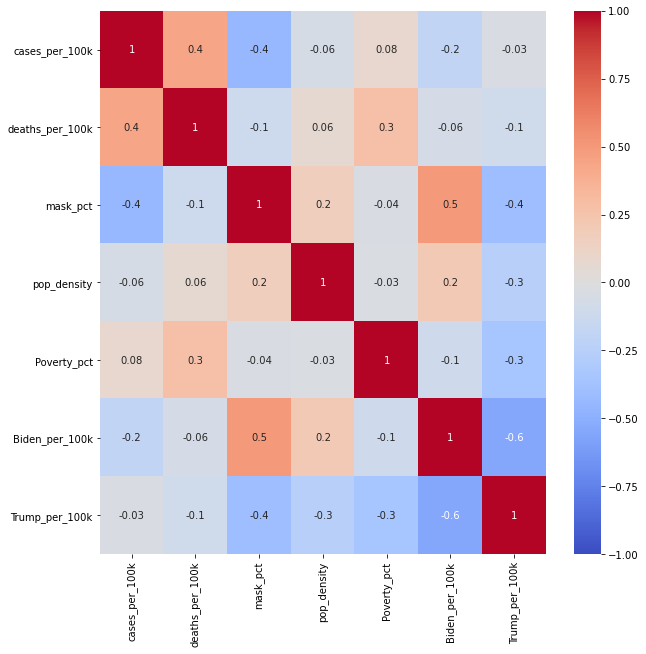

In [34]:
# Print a heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(RDF[['cases_per_100k','deaths_per_100k','mask_pct','pop_density','Poverty_pct','Biden_per_100k','Trump_per_100k']].corr(), annot = True, fmt = '0.1g', cmap = 'coolwarm', vmin=-1)

In [35]:
# Create some very macabre fits.
deaths_fit = sm.OLS(RDF['deaths_per_100k'],sm.add_constant(RDF[['Poverty_pct','pop_density','mask_pct','Biden_per_100k','Trump_per_100k']])).fit()

print(deaths_fit.summary())

                            OLS Regression Results                            
Dep. Variable:        deaths_per_100k   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     64.07
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           9.74e-64
Time:                        12:03:50   Log-Likelihood:                -17339.
No. Observations:                3043   AIC:                         3.469e+04
Df Residuals:                    3037   BIC:                         3.473e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            109.0943     14.317      7.

In [36]:
cases_fit = sm.OLS(RDF['cases_per_100k'],sm.add_constant(RDF[['Poverty_pct','pop_density','mask_pct','Biden_per_100k','Trump_per_100k']])).fit()

print(cases_fit.summary())

                            OLS Regression Results                            
Dep. Variable:         cases_per_100k   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     212.3
Date:                Mon, 14 Dec 2020   Prob (F-statistic):          1.15e-194
Time:                        12:03:51   Log-Likelihood:                -27700.
No. Observations:                3043   AIC:                         5.541e+04
Df Residuals:                    3037   BIC:                         5.545e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.649e+04    431.086     38.

In [37]:
#we want to predict Florida's Data, so separate out for Training and Test data
mask = RDF['State'] == 'FL'

RDF_train = RDF[~mask]
RDF_test = RDF[mask]

In [38]:
RDF_train

,Dates,fips,County Name,State,cases,deaths,POPESTIMATE2018,Poverty_pct,Biden,Trump,land,COUNTYFP,mask_pct,cases_per_100k,deaths_per_100k,pop_density,Biden_per_100k,Trump_per_100k
322,12/9/2020,1001,Autauga County,AL,3117,42,55533,13.8,7503,19838,604.49,1001,0.739,5612.878829,75.630706,91.867525,13510.885419,35722.903499
645,12/9/2020,1003,Baldwin County,AL,10087,141,217855,9.8,24578,83544,2027.08,1003,0.759,4630.143903,64.721948,107.472325,11281.815887,38348.442772
968,12/9/2020,1005,Barbour County,AL,1245,30,24872,30.9,4816,5622,904.59,1005,0.692,5005.628820,120.617562,27.495329,19363.139273,22603.731103
1291,12/9/2020,1007,Bibb County,AL,1322,39,22367,21.8,1986,7525,625.50,1007,0.850,5910.493137,174.364018,35.758593,8879.152323,33643.313811
1614,12/9/2020,1009,Blount County,AL,3496,47,57771,13.2,2640,24711,650.65,1009,0.653,6051.479116,81.355697,88.789672,4569.766838,42774.056187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981596,12/9/2020,56037,Sweetwater County,WY,2245,13,42858,8.4,3823,12229,10491.73,56037,0.414,5238.228569,30.332727,4.084932,8920.154930,28533.762658
981919,12/9/2020,56039,Teton County,WY,1834,2,23269,6.3,9848,4341,4221.96,56039,0.587,7881.731058,8.595127,5.511421,42322.403197,18655.722206
982242,12/9/2020,56041,Uinta County,WY,1250,7,20292,10.0,1591,7496,2087.66,56041,0.471,6160.063079,34.496353,9.719974,7840.528287,36940.666272
982565,12/9/2020,56043,Washakie County,WY,586,11,7877,11.9,651,3245,2242.85,56043,0.572,7439.380475,139.647074,3.512049,8264.567729,41195.886759


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c23ab20>,
      dtype=object)

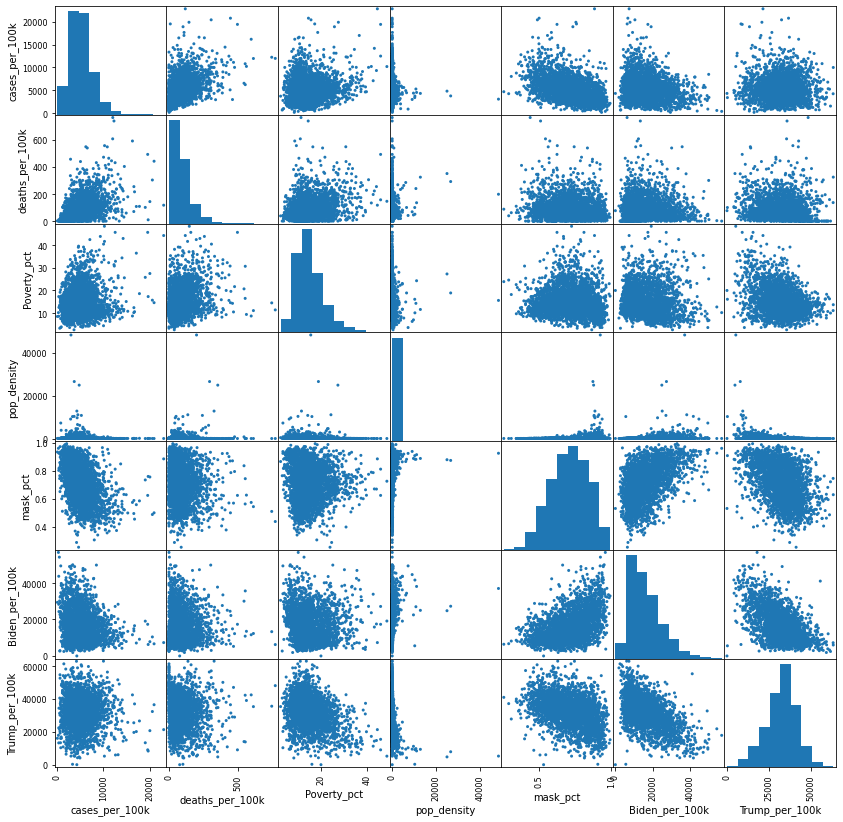

In [39]:
#should be looking at scatter of training data, not all data
pd.plotting.scatter_matrix(RDF_train[['cases_per_100k','deaths_per_100k','Poverty_pct','pop_density','mask_pct','Biden_per_100k','Trump_per_100k']], figsize = (14,14), alpha = 1)

In [40]:
#let's try k-nearest neighbors
knn1 = KNeighborsClassifier(1)
knn10 = KNeighborsClassifier(10)

In [46]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.base import clone

In [67]:
knn1 = KNeighborsRegressor(1)
knn5 = KNeighborsRegressor(5)
knn10 = KNeighborsRegressor(10)

In [54]:
X_train = RDF_train[['Poverty_pct','pop_density','mask_pct','Biden_per_100k','Trump_per_100k']]
y_cases_train = RDF_train['cases_per_100k']
y_deaths_train = RDF_train['deaths_per_100k']

X_test = RDF_test[['Poverty_pct','pop_density','mask_pct','Biden_per_100k','Trump_per_100k']]
y_cases_test = RDF_test['cases_per_100k']
y_deaths_test = RDF_test['deaths_per_100k']

In [49]:
# Making function to calculate various stats
## Accuracy
from sklearn.metrics import accuracy_score
## Precision
from sklearn.metrics import precision_score
## Recall
from sklearn.metrics import recall_score

In [52]:
X_train.index

Int64Index([   322,    645,    968,   1291,   1614,   1937,   2260,   2583,
              2906,   3229,
            ...
            979981, 980304, 980627, 980950, 981273, 981596, 981919, 982242,
            982565, 982888],
           dtype='int64', length=2976)

In [51]:
#cross-validation on cases
kfold = StratifiedKFold(n_splits=5,shuffle = True,random_state=440)
X_train_copy=X_train.copy()

#how many neighbors to try
n=15

accs = np.zeros((5,n))
precs = np.zeros((5,n))
recs = np.zeros((5,n))

for j in range(1,n+1):
    print(j)
    knn = KNeighborsRegressor(j)
    
    i = 0
    for train_index,test_index in kfold.split(X_train_copy,y_cases_train):
        X_train_train, X_train_test = X_train_copy.iloc[train_index],X_train_copy.iloc[test_index]
        y_cases_train_train, y_cases_train_test = y_cases_train.iloc[train_index],y_cases_train.iloc[test_index]

        knn_clone = clone(knn)
        knn_clone.fit(X_train_train,y_cases_train_train)
        
        y_predict = knn_clone.predict(X_train_test)
        accs[i,j-1] = accuracy_score(y_cases_train_test,y_predict)
        precs[i,j-1] = precision_score(y_cases_train_test,y_predict)
        recs[i,j-1] = recall_score(y_cases_train_test,y_predict)
        i = i + 1

1


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

In [ ]:
# Plot that mean cv measure against max_depth
plt.figure(figsize=(14,10))

plt.plot(range(1,n+1), np.mean(accs,axis=0),'b-o', label="Accuracy")
plt.plot(range(1,n+1), np.mean(precs,axis=0),'r-o', label="Precision")
plt.plot(range(1,n+1), np.mean(recs,axis=0),'g-o', label="Recall")

plt.ylabel("Mean CV Performance Score",fontsize=16)
plt.xlabel("Max Depth",fontsize=16)

plt.legend(fontsize=16)

plt.show()




In [68]:
#first try cases
knn1.fit(X_train, y_cases_train)
knn5.fit(X_train, y_cases_train)
knn10.fit(X_train, y_cases_train)


KNeighborsRegressor(n_neighbors=10)

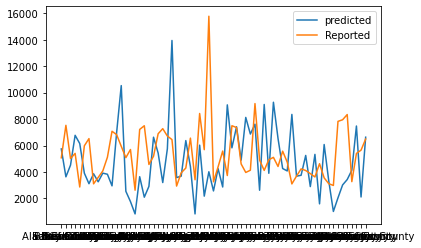

In [69]:
#1 Neighbor
plt.plot(RDF_test['County Name'], knn1.predict(X_test), label = 'predicted')
plt.plot(RDF_test['County Name'], y_cases_test, label = 'Reported')
plt.legend()

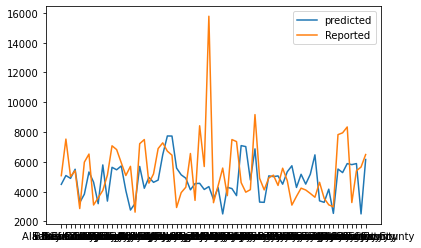

In [70]:
#5 Neighbors
plt.plot(RDF_test['County Name'], knn5.predict(X_test), label = 'predicted')
plt.plot(RDF_test['County Name'], y_cases_test, label = 'Reported')
plt.legend()

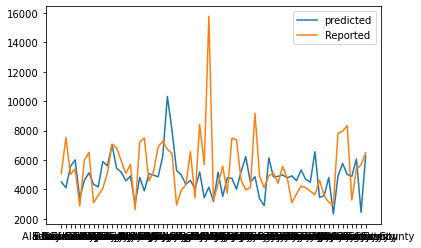

In [71]:
#10 Neighbors
plt.plot(RDF_test['County Name'], knn10.predict(X_test), label = 'predicted')
plt.plot(RDF_test['County Name'], y_cases_test, label = 'Reported')
plt.legend()

In [72]:
knn1.fit(X_train, y_deaths_train)
knn5.fit(X_train, y_deaths_train)
knn10.fit(X_train, y_deaths_train)

KNeighborsRegressor(n_neighbors=10)

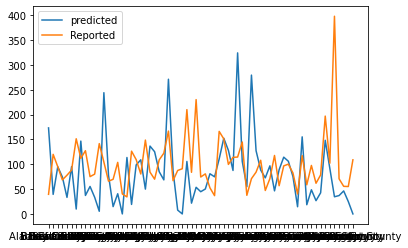

In [73]:
#1 Neighbor
plt.plot(RDF_test['County Name'], knn1.predict(X_test), label = 'predicted')
plt.plot(RDF_test['County Name'], y_deaths_test, label = 'Reported')
plt.legend()

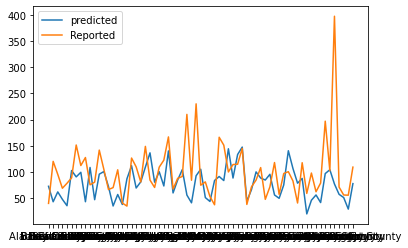

In [74]:
#5 Neighbors
plt.plot(RDF_test['County Name'], knn5.predict(X_test), label = 'predicted')
plt.plot(RDF_test['County Name'], y_deaths_test, label = 'Reported')
plt.legend()

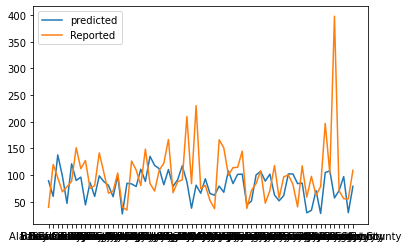

In [75]:
#10 Neighbors
plt.plot(RDF_test['County Name'], knn10.predict(X_test), label = 'predicted')
plt.plot(RDF_test['County Name'], y_deaths_test, label = 'Reported')
plt.legend()

In [57]:
#Check accuracy, etc (try different depths)
#cross-validation on cases
kfold = StratifiedKFold(n_splits=5,shuffle = True,random_state=440)
X_train_copy=X_train.copy()

#max depth
n=40

accs = np.zeros((5,n))
precs = np.zeros((5,n))
recs = np.zeros((5,n))

for j in range(1,n+1):
    print(j)
    rf = RandomForestRegressor(n_estimators = 500,max_depth=j, random_state = 440)
    
    i = 0
    for train_index,test_index in kfold.split(X_train_copy,y_cases_train):
        X_train_train, X_train_test = X_train_copy.iloc[train_index],X_train_copy.iloc[test_index]
        y_cases_train_train, y_cases_train_test = y_cases_train.iloc[train_index],y_cases_train.iloc[test_index]

        rf_clone = clone(rf)
        rf_clone.fit(X_train_train,y_cases_train_train)
        
        y_predict = rf_clone.predict(X_train_test)
        accs[i,j-1] = accuracy_score(y_cases_train_test,y_predict)
        precs[i,j-1] = precision_score(y_cases_train_test,y_predict)
        recs[i,j-1] = recall_score(y_cases_train_test,y_predict)
        i = i + 1

1


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

In [ ]:
regr_c = RandomForestRegressor(max_depth = 40)

In [ ]:
X_train = RDF_train[['Poverty_pct','pop_density','mask_pct','Biden_per_100k','Trump_per_100k']]
y_cases_train = RDF_train['cases_per_100k']
y_deaths_train = RDF_train['deaths_per_100k']

X_test = RDF_test[['Poverty_pct','pop_density','mask_pct','Biden_per_100k','Trump_per_100k']]
y_cases_test = RDF_test['cases_per_100k']
y_deaths_test = RDF_test['deaths_per_100k']

In [ ]:
regr_c.fit(X_train, y_cases_train)

In [ ]:
plt.plot(RDF_test['County Name'], regr_c.predict(X_test), label = 'predicted')
plt.plot(RDF_test['County Name'], y_cases_test, label = 'Reported')
plt.legend()

In [ ]:
regr_d = RandomForestRegressor(max_depth = 40)
regr_d.fit(X_train, y_deaths_train)

In [ ]:
plt.plot(RDF_test['County Name'], regr_d.predict(X_test), label = 'predicted')
plt.plot(RDF_test['County Name'], y_deaths_test, label = 'Reported')
plt.legend()